### Importing necessary libraries

In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

#Date time
import datetime as dt
from datetime import timedelta, date

# Visualization
import ipyleaflet
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd
import geopandas

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report,confusion_matrix
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
import torch


# Planetary Computer Tools
import pystac
import pystac_client
import stackstac
import odc
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load
import planetary_computer as pc
import contextily
pc.settings.set_subscription_key('#########################################')

# Others
import requests
import rich.table
from itertools import cycle
from tqdm import tqdm
tqdm.pandas()

#Scaling using Dask
import dask_gateway
import dask
import xarray as xr
from dask.distributed import Client
import dask.array as da
import dask.dataframe as dd

In [2]:
crop_presence_data = pd.read_csv("./Data/Crop_Location_Data_20221201.csv")
crop_presence_data.head()

,Latitude and Longitude,Class of Land
0,"(28.211240, 83.402295)",Rice
1,"(10.323727047081501, 105.2516346045924)",Rice
2,"(10.322364360592521, 105.27843410554115)",Rice
3,"(10.321455902933202, 105.25254306225168)",Rice
4,"(10.324181275911162, 105.25118037576274)",Rice


### Creating bounding boxes from the given coordinate

In [3]:
def calculate_bbox(lat_long, box_size_deg=0.0004):
    lat_long=lat_long.replace('(','').replace(')','').replace(' ','').split(',')
    
    min_lon = float(lat_long[1]) - box_size_deg/2
    min_lat = float(lat_long[0])- box_size_deg/2
    max_lon = float(lat_long[1]) + box_size_deg/2
    max_lat = float(lat_long[0]) + box_size_deg/2
    
    return min_lon, min_lat, max_lon, max_lat

#### Defining variables 

In [1]:
time_of_interest = '2021-12-01/2022-11-30'
resolution = 10  # meters per pixel 
scale = resolution / 111320.0 # degrees per pixel for crs=4326 

In [6]:
rvi_df = pd.DataFrame() 
bbox = []
for coordinates in tqdm(crop_presence_data['Latitude and Longitude']):
    bbox.append(calculate_bbox(coordinates))

bbox_data = pd.DataFrame(bbox,columns =['min_lon', 'min_lat', 'max_lon', 'max_lat'])

100%|████████████████████████████████████████████████████████████████████████████| 601/601 [00:00<00:00, 194279.51it/s]


#### Dask

### New approach

In [7]:
bbox_data

,min_lon,min_lat,max_lon,max_lat
0,83.402095,28.211040,83.402495,28.211440
1,105.251435,10.323527,105.251835,10.323927
2,105.278234,10.322164,105.278634,10.322564
3,105.252343,10.321256,105.252743,10.321656
4,105.250980,10.323981,105.251380,10.324381
...,...,...,...,...
596,105.673413,10.013743,105.673813,10.014143
597,105.673413,10.013289,105.673813,10.013689
598,105.673413,10.012835,105.673813,10.013235
599,105.673413,10.012380,105.673813,10.012780


In [8]:
def create_rvi_for_each_aoi(time_of_interest, bbox):
    #Creating catalog
    catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    search = catalog.search(collections=["sentinel-1-rtc"], bbox=bbox, datetime=time_of_interest)
    items = search.get_all_items()
    # Load the data using Open Data Cube
    data = stac_load(items,bands=["vv", "vh"], patch_url=pc.sign, bbox=bbox, chunks={"time":10, "x": 307200, "y": 307200},
                     crs="EPSG:4326", resolution=scale)
    print(data)
    mean_aoi = data.mean(dim=['latitude','longitude'])
    
    data['vh'] = mean_aoi["vh"]
    data['vv'] = mean_aoi["vv"]

    dop = (mean_aoi.vv / (mean_aoi.vv + mean_aoi.vh))
    m = 1 - dop
    data['rvi'] = (np.sqrt(dop))*((4*mean_aoi.vh)/(mean_aoi.vv + mean_aoi.vh))
    return data

#### Creating Data

In [9]:
for i in range(600):
    vh=[]
    vv=[]
    rvi=[]
    ds = create_rvi_for_each_aoi(time_of_interest,bbox_data.iloc[i])
    
    vh= ds.vh.compute().to_series()
    vv= ds.vv.compute().to_series()
    rvi= ds.rvi.compute().to_series()
    ground_truth_location= crop_presence_data.iloc[i]['Latitude and Longitude']
    ground_truth_landclass= crop_presence_data.iloc[i]['Class of Land']
    ground_truth = {'Location': ground_truth_location , 'Class_of_Land': ground_truth_landclass}
    ground_truth_data = pd.DataFrame(data=ground_truth, index= [i])    
    frame = { 'VV': vv, 'VH': vh, 'RVI': rvi, 'Location': crop_presence_data.iloc[i]['Latitude and Longitude'], 
             'Class_of_Land': ground_truth_landclass}
    vh_vv_rvi_data = pd.DataFrame(frame)
    vh_vv_rvi_data.to_csv('rvi-test.csv', mode='a', index=True, header=False)

<xarray.Dataset>
Dimensions:      (latitude: 5, longitude: 5, time: 4)
Coordinates:
  * latitude     (latitude) float64 28.21 28.21 28.21 28.21 28.21
  * longitude    (longitude) float64 83.4 83.4 83.4 83.4 83.4
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2022-08-02T00:19:51.493490 ... 2022-08...
Data variables:
    vv           (time, latitude, longitude) float32 dask.array<chunksize=(1, 5, 5), meta=np.ndarray>
    vh           (time, latitude, longitude) float32 dask.array<chunksize=(1, 5, 5), meta=np.ndarray>
<xarray.Dataset>
Dimensions:      (latitude: 5, longitude: 6, time: 3)
Coordinates:
  * latitude     (latitude) float64 10.32 10.32 10.32 10.32 10.32
  * longitude    (longitude) float64 105.3 105.3 105.3 105.3 105.3 105.3
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2022-08-01T22:46:12.528362 ... 2022-08...
Data variables:
    vv           (time, latitude, longitude) float32 dask.array<chunksize=(1, 5, 6), meta=np.ndarray>
    vh   

In [10]:
vh_vv_rvi_data.head()

,VV,VH,RVI,Location,Class_of_Land
time,,,,,
2022-08-01 22:46:12.528362,0.094485,0.020887,0.655351,"(10.323727047081501, 105.2516346045924)",Rice
2022-08-02 11:11:59.338449,0.085478,0.011113,0.432936,"(10.323727047081501, 105.2516346045924)",Rice
2022-08-14 11:12:00.071377,0.046614,0.006730,0.471715,"(10.323727047081501, 105.2516346045924)",Rice


#### Merging multiple csv files and creating a single file

In [79]:
import os
import glob
import pandas as pd
# merging the files
joined_files = os.path.join("./Data/Temp/", "rvi-*.csv")
  
# A list of all joined files is returned
joined_list = glob.glob(joined_files)

In [80]:
final_rice_df = pd.concat(map(pd.read_csv, joined_list), ignore_index=True)

In [81]:
final_rice_df.shape

(36600, 6)

In [82]:
final_rice_df.head()

,image_taken,VV,VH,RVI,location,Class_of_Land
0,10/03/2022,0.089866,0.032007,0.902072,"(10.323727047081501, 105.2516346045924)",Rice
1,11/03/2022,0.050158,0.029283,1.171599,"(10.323727047081501, 105.2516346045924)",Rice
2,22/03/2022,0.222246,0.070375,0.838371,"(10.323727047081501, 105.2516346045924)",Rice
3,23/03/2022,0.098687,0.037883,0.943192,"(10.323727047081501, 105.2516346045924)",Rice
4,10/03/2022,0.315821,0.049165,0.501215,"(10.322364360592521, 105.27843410554115)",Rice


In [83]:
final_rice_df.apply(lambda x: sum(x.isnull()), axis = 0)

image_taken      0
VV               0
VH               0
RVI              0
location         0
Class_of_Land    0
dtype: int64

In [34]:
final_rice_df.dropna()

,image_taken,VV,VH,RVI,location,Class_of_Land
0,10/03/2022,0.089866,0.032007,0.902072,"(10.323727047081501, 105.2516346045924)",Rice
1,11/03/2022,0.050158,0.029283,1.171599,"(10.323727047081501, 105.2516346045924)",Rice
2,22/03/2022,0.222246,0.070375,0.838371,"(10.323727047081501, 105.2516346045924)",Rice
3,23/03/2022,0.098687,0.037883,0.943192,"(10.323727047081501, 105.2516346045924)",Rice
4,10/03/2022,0.315821,0.049165,0.501215,"(10.322364360592521, 105.27843410554115)",Rice
...,...,...,...,...,...,...
36595,06/09/2022,0.437144,0.059023,0.446633,"(10.012126069934741, 105.67361318732796)",Non Rice
36596,07/09/2022,0.129796,0.067208,1.107641,"(10.012126069934741, 105.67361318732796)",Non Rice
36597,18/09/2022,0.250619,0.081351,0.851692,"(10.012126069934741, 105.67361318732796)",Non Rice
36598,19/09/2022,0.283836,0.077845,0.762670,"(10.012126069934741, 105.67361318732796)",Non Rice


**Adding Month variable**

In [84]:
final_rice_df['month'] = pd.to_datetime(final_rice_df['image_taken'])

In [85]:
final_rice_df['month'] = final_rice_df['month'].dt.month

In [86]:
final_rice_df['month']

0        10
1        11
2         3
3         3
4        10
         ..
36595     6
36596     7
36597     9
36598     9
36599     9
Name: month, Length: 36600, dtype: int64

**Creating additional features: VRAT, SPAN, Diff**

In [87]:
final_rice_df['VRAT'] = final_rice_df['VV'] / final_rice_df['VH']

In [88]:
final_rice_df['span']= final_rice_df['VH'] + final_rice_df['VV']

In [89]:
final_rice_df['diff']= final_rice_df['VV'] - final_rice_df['VH']

In [90]:
from datetime import datetime
date_format = "%d/%m/%Y"

b = datetime.strptime('01/12/2021', date_format)

final_rice_df['Day_of_Year'] = pd.to_datetime(final_rice_df['image_taken'], format =date_format) - b

In [91]:
final_rice_df['Day_of_Year'] = final_rice_df['Day_of_Year'].dt.days


In [92]:
final_rice_df['Day_of_Year']

0         99
1        100
2        111
3        112
4         99
        ... 
36595    279
36596    280
36597    291
36598    292
36599    303
Name: Day_of_Year, Length: 36600, dtype: int64

**Exploratory Data Analysis**

In [93]:
final_rice_df.describe()

,VV,VH,RVI,month,VRAT,span,diff,Day_of_Year
count,36600.000000,36600.000000,36600.000000,36600.000000,36600.000000,36600.000000,36600.000000,36600.000000
mean,0.157005,0.034366,0.724666,6.688525,5.353286,0.191372,0.122639,177.590164
std,0.147482,0.025968,0.257823,3.541563,5.652030,0.164622,0.133231,111.068825
min,0.003976,0.001901,0.016705,1.000000,0.736166,0.007550,-0.008665,3.000000
25%,0.044888,0.007984,0.567359,4.000000,2.830926,0.060123,0.027173,76.000000
50%,0.134730,0.030811,0.730420,6.000000,3.883526,0.169574,0.098960,172.000000
75%,0.243003,0.053042,0.897571,10.000000,5.483768,0.297476,0.188743,279.000000
max,12.621059,0.257068,1.500241,12.000000,237.951286,12.674100,12.568018,364.000000


In [45]:
final_rice_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36600 entries, 0 to 36599
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   image_taken    36600 non-null  object 
 1   VV             36600 non-null  float64
 2   VH             36600 non-null  float64
 3   RVI            36600 non-null  float64
 4   location       36600 non-null  object 
 5   Class_of_Land  36600 non-null  object 
 6   month          36600 non-null  int64  
 7   VRAT           36600 non-null  float64
 8   span           36600 non-null  float64
 9   diff           36600 non-null  float64
 10  Day_of_Year    36600 non-null  int64  
dtypes: float64(6), int64(2), object(3)
memory usage: 3.1+ MB


In [46]:
final_rice_df.VV.describe()

count    36600.000000
mean         0.157005
std          0.147482
min          0.003976
25%          0.044888
50%          0.134730
75%          0.243003
max         12.621059
Name: VV, dtype: float64

In [40]:
final_rice_df.skew()

VV               19.143836
VH                0.723030
RVI              -0.152746
Class_of_Land     0.000000
month            -0.039213
VRAT              7.568940
span             13.948008
diff             25.716982
Day_of_Year       0.049628
dtype: float64

<AxesSubplot: title={'center': 'VV'}, xlabel='Class_of_Land'>

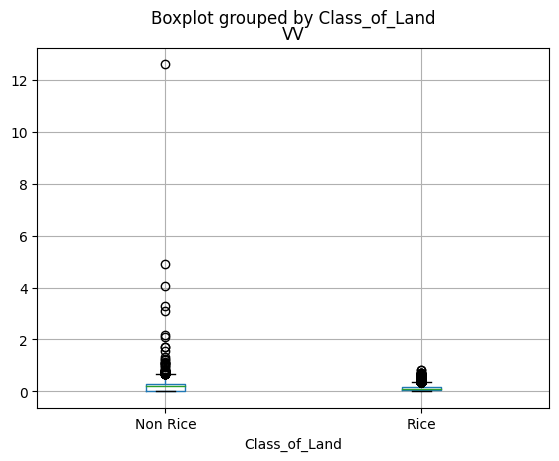

In [47]:
final_rice_df.boxplot(column='VV', by="Class_of_Land")

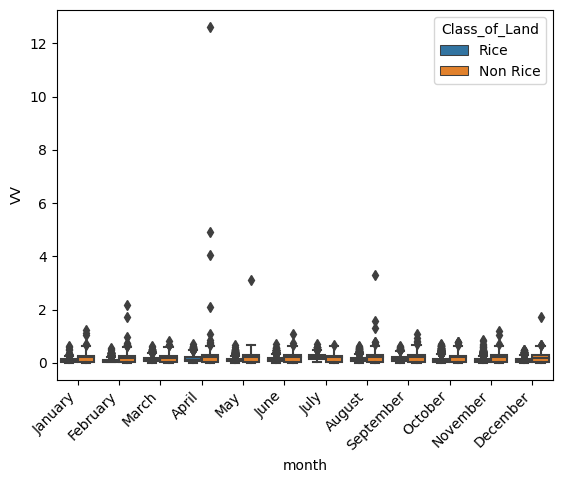

In [94]:
sns.boxplot(data=final_rice_df, x="month", y="VV", hue='Class_of_Land')
locs, labels = plt.xticks()
plt.xticks(np.arange(0,12), ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.xticks (rotation=45, ha='right')
plt.savefig('MeanVV.png')

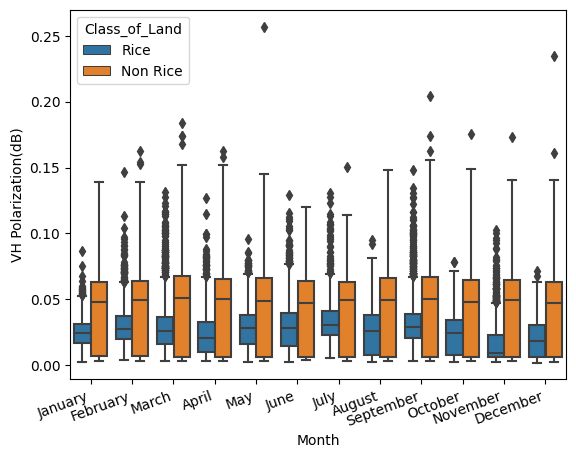

In [95]:
sns.boxplot(data=final_rice_df, x="month", y="VH", hue='Class_of_Land')
locs, labels = plt.xticks()
plt.xticks(np.arange(0,12), ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.xticks (rotation=20, ha='right')
plt.xlabel('Month')
plt.ylabel('VH Polarization(dB)')
plt.savefig('MeanVH.png')

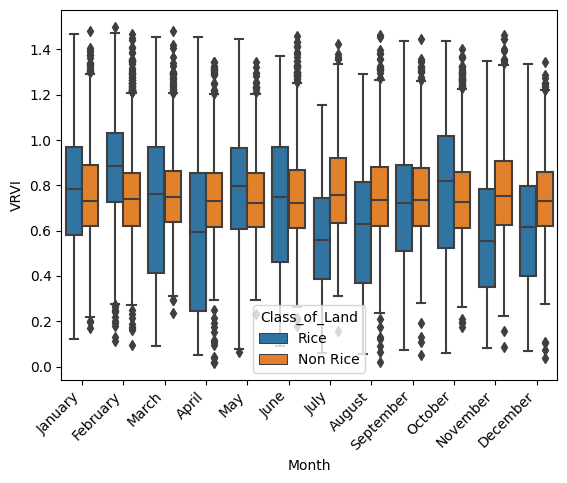

In [96]:
sns.boxplot(data=final_rice_df, x="month", y="RVI", hue='Class_of_Land')
locs, labels = plt.xticks()
plt.xticks(np.arange(0,12), ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.xticks (rotation=45, ha='right')
plt.xlabel('Month')
plt.ylabel('VRVI')
plt.savefig('MeanRVI.png')

In [97]:
df_only_rice = final_rice_df[final_rice_df['Class_of_Land'] == 'Rice']
df_only_nonrice = final_rice_df[final_rice_df['Class_of_Land'] == 'Non Rice']

print(df_only_rice.describe())
print('--------------------')
print(df_only_nonrice.describe())

#sns.distplot(df_only_rice['VH'], kde=False, bins=10)
#sns.distplot(df_only_nonrice['VH'], kde=False, bins=10)



                 VV            VH           RVI         month          VRAT  \
count  18300.000000  18300.000000  18300.000000  18300.000000  18300.000000   
mean       0.128685      0.025846      0.692790      6.688525      6.569713   
std        0.102296      0.017466      0.304130      3.541612      6.969429   
min        0.003976      0.001901      0.052826      1.000000      0.736166   
25%        0.056962      0.010962      0.455923      4.000000      2.687658   
50%        0.099472      0.024813      0.721801      6.000000      3.950433   
75%        0.171024      0.034995      0.926022     10.000000      7.222637   
max        0.840178      0.148200      1.500241     12.000000     74.215596   

               span          diff   Day_of_Year  
count  18300.000000  18300.000000  18300.000000  
mean       0.154532      0.102839    177.590164  
std        0.109579      0.097629    111.070342  
min        0.007550     -0.008665      3.000000  
25%        0.077326      0.035059     

In [98]:
#5-River, 6-OtherFields, 7-Residence
AOI1 = final_rice_df.loc[final_rice_df['location']=='(10.323727047081501, 105.2516346045924)']
AOI2 = final_rice_df.loc[final_rice_df['location']=='(10.322364360592521, 105.27843410554115)']
AOI3 = final_rice_df.loc[final_rice_df['location']=='(10.012126069934741, 105.67361318732796)']
AOI4 = final_rice_df.loc[final_rice_df['location']=='(10.009400696956781, 105.67225050083903)']
AOI5 = final_rice_df.loc[final_rice_df['location']=='(10.321455902933202, 105.49555548610908)']
AOI6 = final_rice_df.loc[final_rice_df['location']=='(10.481616988271316, 104.91150805695796)']
AOI7 = final_rice_df.loc[final_rice_df['location']=='(10.007583781638141, 105.67270472966868)']

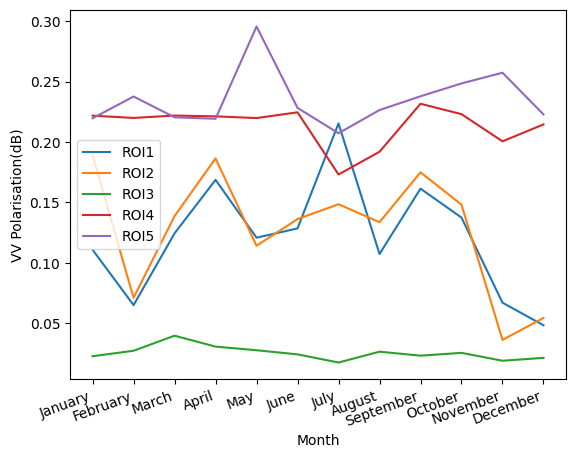

In [99]:
sns.lineplot(x = "month", y = "VV", data=AOI1, legend='auto', style=None, ci=None)
sns.lineplot(x = "month", y = "VV", data=AOI2, legend='auto', style=None, ci=None)
sns.lineplot(x = "month", y = "VV", data=AOI5, legend='auto', style=None, ci=None)
sns.lineplot(x = "month", y = "VV", data=AOI6, legend='auto', style=None, ci=None)
sns.lineplot(x = "month", y = "VV", data=AOI4, legend='auto', style=None, ci=None)

plt.xlabel('Month')
plt.ylabel('VV Polarisation(dB)')
#plt.set_xticks(xlabel)
plt.legend(labels = ['ROI1', 'ROI2', 'ROI3', 'ROI4', 'ROI5'])
locs, labels = plt.xticks()
plt.xticks(np.arange(1,13), ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.xticks (rotation=20, ha='right')
plt.savefig('vv.png')
plt.show()

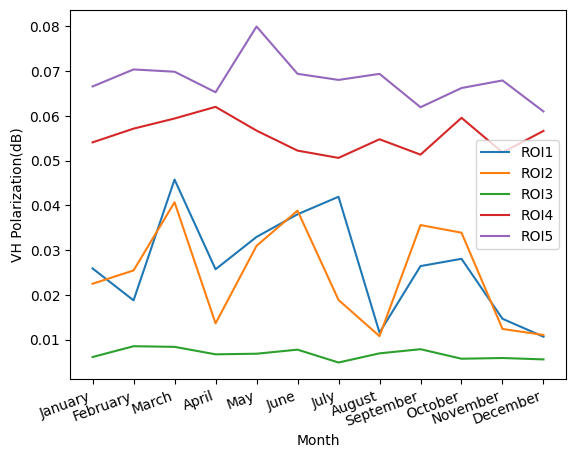

In [58]:
fig, ax = plt.subplots()
sns.lineplot(x = "month", y = "VH", data=AOI1, legend='auto', style=None, ci=None)
sns.lineplot(x = "month", y = "VH", data=AOI2, legend='auto', style=None, ci=None)
sns.lineplot(x = "month", y = "VH", data=AOI5, legend='auto', style=None, ci=None)
sns.lineplot(x = "month", y = "VH", data=AOI6, legend='auto', style=None, ci=None)
sns.lineplot(x = "month", y = "VH", data=AOI4, legend='auto', style=None, ci=None)
xlabel = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 
          'October', 'November', 'December']
#locs, labels = xticks()
#xticks([1, 2, 3,4,5,6,7,8,9,10,11,12], ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], rotation=20) 
plt.xlabel('Month')
plt.ylabel('VH Polarization(dB)')
plt.legend(labels = ['ROI1', 'ROI2', 'ROI3', 'ROI4', 'ROI5'])
locs, labels = plt.xticks()
plt.xticks(np.arange(1,13), ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.xticks (rotation=20, ha='right')

plt.savefig('vh.png')
plt.show()


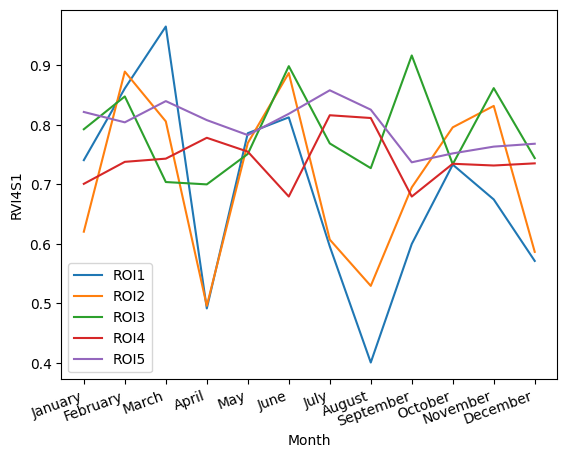

In [34]:
#fig, ax = plt.subplots(figsize=(10, 10))

sns.lineplot(x = "month", y = "RVI", data=AOI1, legend='auto', style=None, ci=None)
sns.lineplot(x = "month", y = "RVI", data=AOI2, legend='auto', style=None, ci=None)
sns.lineplot(x = "month", y = "RVI", data=AOI5, legend='auto', style=None, ci=None)
sns.lineplot(x = "month", y = "RVI", data=AOI6, legend='auto', style=None, ci=None)
sns.lineplot(x = "month", y = "RVI", data=AOI4, legend='auto', style=None, ci=None)

plt.xlabel('Month')
plt.ylabel('RVI4S1')
plt.legend(labels = ['ROI1', 'ROI2', 'ROI3', 'ROI4', 'ROI5'])
locs, labels = plt.xticks()
plt.xticks(np.arange(1,13), ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.xticks (rotation=20, ha='right')
plt.savefig('rvi.png')
plt.show()


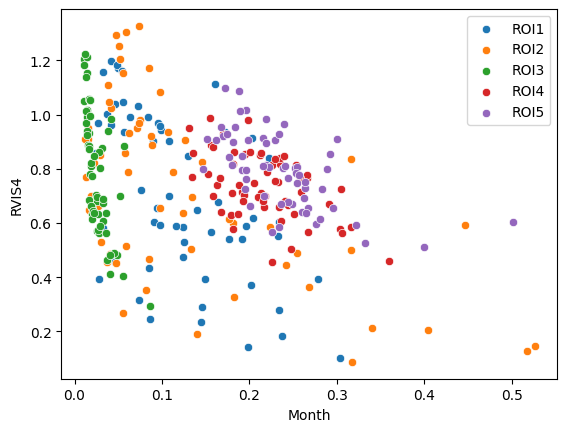

In [59]:
#fig, ax = plt.subplots(figsize=(10, 10))

sns.scatterplot(x = "VV", y = "RVI", data=AOI1, legend='auto', style=None)
sns.scatterplot(x = "VV", y = "RVI", data=AOI2, legend='auto', style=None)
sns.scatterplot(x = "VV", y = "RVI", data=AOI5, legend='auto', style=None)
sns.scatterplot(x = "VV", y = "RVI", data=AOI6, legend='auto', style=None)
sns.scatterplot(x = "VV", y = "RVI", data=AOI4, legend='auto', style=None)

plt.xlabel('Month')
plt.ylabel('RVIS4')
plt.legend(labels = ['ROI1', 'ROI2', 'ROI3', 'ROI4', 'ROI5'])

plt.savefig('rvi.png')
plt.show()


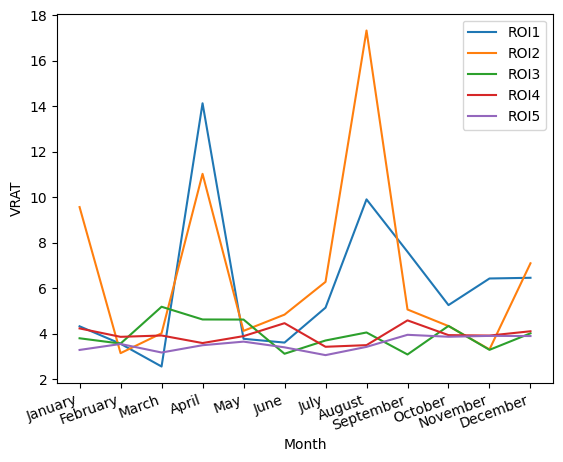

In [60]:
#fig, ax = plt.subplots(figsize=(10, 10))

sns.lineplot(x = "month", y = "VRAT", data=AOI1, legend='auto', style=None, ci=None)
sns.lineplot(x = "month", y = "VRAT", data=AOI2, legend='auto', style=None, ci=None)
sns.lineplot(x = "month", y = "VRAT", data=AOI5, legend='auto', style=None, ci=None)
sns.lineplot(x = "month", y = "VRAT", data=AOI6, legend='auto', style=None, ci=None)
sns.lineplot(x = "month", y = "VRAT", data=AOI4, legend='auto', style=None, ci=None)

plt.xlabel('Month')
plt.ylabel('VRAT')
plt.legend(labels = ['ROI1', 'ROI2', 'ROI3', 'ROI4', 'ROI5'])
locs, labels = plt.xticks()
plt.xticks(np.arange(1,13), ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.xticks (rotation=20, ha='right')
plt.savefig('VRAT.png')
plt.show()


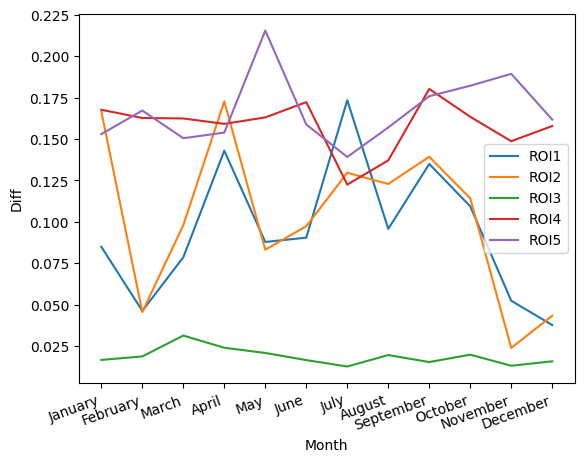

In [62]:
#fig, ax = plt.subplots(figsize=(10, 10))

sns.lineplot(x = "month", y = "diff", data=AOI1, legend='auto', style=None, ci=None)
sns.lineplot(x = "month", y = "diff", data=AOI2, legend='auto', style=None, ci=None)
sns.lineplot(x = "month", y = "diff", data=AOI5, legend='auto', style=None, ci=None)
sns.lineplot(x = "month", y = "diff", data=AOI6, legend='auto', style=None, ci=None)
sns.lineplot(x = "month", y = "diff", data=AOI4, legend='auto', style=None, ci=None)

plt.xlabel('Month')
plt.ylabel('Diff')
plt.legend(labels = ['ROI1', 'ROI2', 'ROI3', 'ROI4', 'ROI5'])
locs, labels = plt.xticks()
plt.xticks(np.arange(1,13), ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.xticks (rotation=20, ha='right')
plt.savefig('diff.png')
plt.show()


In [100]:
import folium


m = folium.Map(location=[10.323727047081501, 105.2516346045924])

folium.Marker(
    location=[10.323727047081501, 105.2516346045924],
    popup="AOI1",
    icon=folium.Icon(icon="rice", color="blue"),
).add_to(m)

folium.Marker(
    location=[10.322364360592521, 105.27843410554115],
    popup="AOI2",
    icon=folium.Icon(icon= "rice", color="orange"),
).add_to(m)

folium.Marker(
    location=[10.321455902933202, 105.49555548610908],
    popup="AOI3",
    icon=folium.Icon(color="green", icon="river"),
).add_to(m)


folium.Marker(
    location=[10.007583781638141, 105.67270472966868],
    popup="AOI4",
    icon=folium.Icon(color="red", icon="building"),
).add_to(m)

folium.Marker(
    location=[10.481616988271316, 104.91150805695796],
    popup="AOI5",
    icon=folium.Icon(color="purple", icon="building"),
).add_to(m)
m

### Correlation

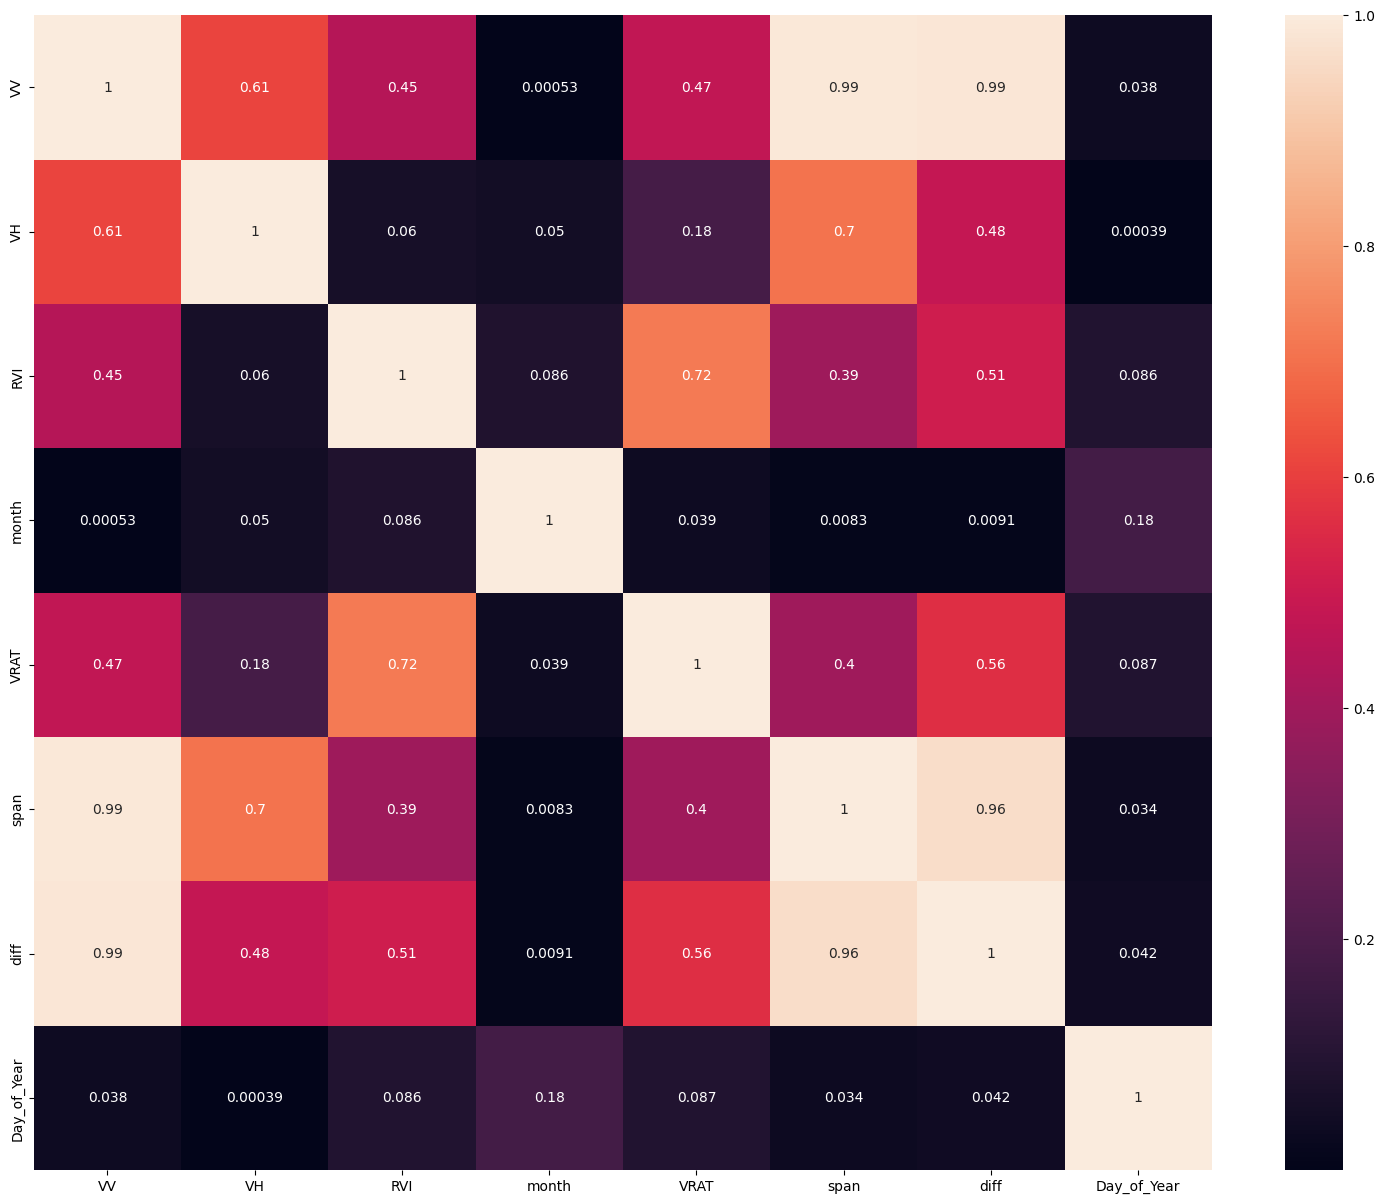

In [101]:
correlation_matrix = final_rice_df.corr().abs()
plt.figure(figsize=(19,15))
sns.heatmap(data=correlation_matrix,annot=True)
plt.savefig('correlation_heatmap.jpeg', dpi=100)
plt.show()

In [103]:
y_cat = LabelEncoder().fit(final_rice_df['Class_of_Land'])
final_rice_df['Class_of_Land'] = y_cat.transform(final_rice_df['Class_of_Land'])

In [104]:
X_reg = final_rice_df.drop(['image_taken','location', 'Class_of_Land','Day_of_Year', 'month'], axis=1)
y_reg= final_rice_df['Class_of_Land']

In [105]:
X_reg= StandardScaler().fit_transform(X_reg)

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.40, random_state=8)

In [107]:
print("X train shape: ", X_train.shape)
print("X test shape: ", X_test.shape)
print("Y train shape: ", y_train.shape)
print("Y test shape: ", y_test.shape)


X train shape:  (21960, 6)
X test shape:  (14640, 6)
Y train shape:  (21960,)
Y test shape:  (14640,)


#### Creating Tabnet classifier model

In [108]:
unsupervised_model = TabNetPretrainer(
optimizer_fn=torch.optim.Adam,
optimizer_params=dict(lr=2e-2),
mask_type="entmax"
)

In [109]:
classifier = TabNetClassifier(optimizer_fn=torch.optim.Adam, optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10,"gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='sparsemax', verbose=0,seed=42)

classifier.fit(X_train=X_train, y_train=y_train,
               eval_set=[(X_train, y_train), (X_test, y_test)],
               max_epochs=100,
               batch_size=512, virtual_batch_size=512,
               eval_metric=['auc', 'balanced_accuracy'])


Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_1_balanced_accuracy = 0.8532


In [110]:
preds = classifier.predict(X_test)

Feature: 0, Score: 0.04557
Feature: 1, Score: 0.29840
Feature: 2, Score: 0.16775
Feature: 3, Score: 0.09374
Feature: 4, Score: 0.16188
Feature: 5, Score: 0.23266


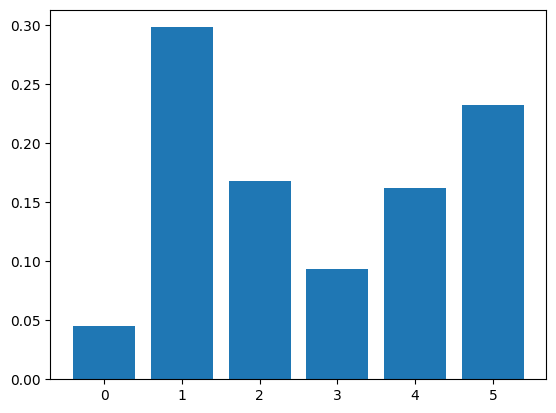

In [111]:
importance = classifier.feature_importances_
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# Barchat for feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [112]:
print("Accuracy {0:.2f}%".format(100*accuracy_score(preds,y_test)))
print("Precision: {0:.2f}%".format(100*precision_score(preds, y_test)))
print("Recall: {0:.2f}%".format(100*recall_score(preds, y_test)))
print("F1 Score: {0:.2f}%".format(100*f1_score(preds, y_test)))
print(classification_report(preds,y_test))

Accuracy 85.31%
Precision: 80.52%
Recall: 89.10%
F1 Score: 84.59%
              precision    recall  f1-score   support

           0       0.90      0.82      0.86      8017
           1       0.81      0.89      0.85      6623

    accuracy                           0.85     14640
   macro avg       0.85      0.86      0.85     14640
weighted avg       0.86      0.85      0.85     14640



In [ ]:
classifier.history

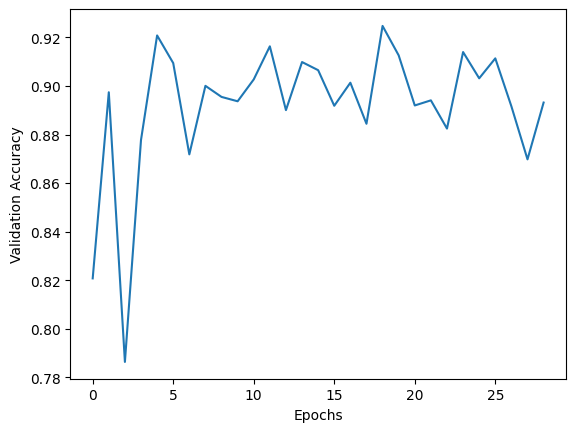

In [113]:
plt.plot(classifier.history['val_0_auc'])
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.savefig('Validation.png')

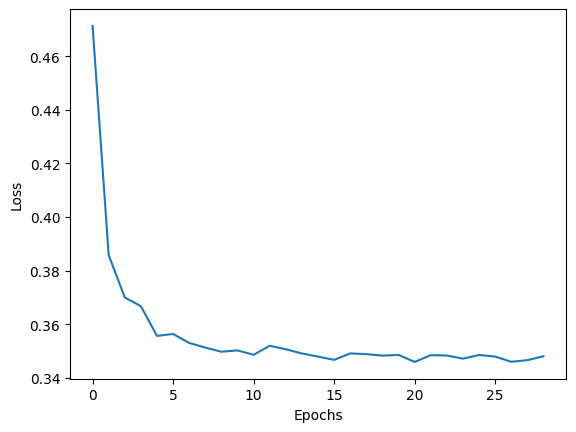

In [114]:
plt.plot(classifier.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('loss.png')

In [115]:
def plot_confusion_matrix(true_value,predicted_value,title,labels):
    cm = confusion_matrix(true_value,predicted_value)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues');
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title(title); 
    ax.xaxis.set_ticklabels(labels); 
    ax.yaxis.set_ticklabels(labels);

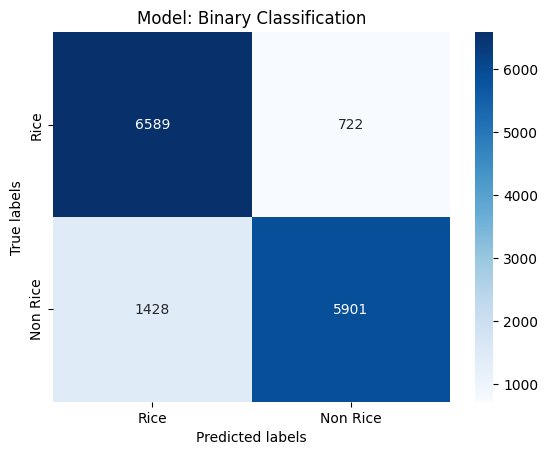

In [116]:
plot_confusion_matrix(y_test, preds,"Model: Binary Classification",['Rice', 'Non Rice'])
plt.savefig('Confusion_matrix.png')

#### Saving Model

In [117]:
saving_path_name = "./Model"
saved_filepath = classifier.save_model(saving_path_name)

# define new model with basic parameters and load state dict weights
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

Successfully saved model at ./Model.zip


### Creating Ensemble learning with cross validation and bagging

In [81]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score

In [82]:
scores = cross_val_score(DecisionTreeClassifier(), X_train, y_train, cv=5)

In [83]:
scores.mean()

0.7891491022638564

In [91]:
bagging_model = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, max_samples=0.8, oob_score=True, random_state=0)
score= cross_val_score(bagging_model, X_train, y_train, cv=5)
score.mean()

0.8401639344262296

In [85]:
from sklearn.ensemble import RandomForestClassifier
score= cross_val_score(RandomForestClassifier(), X_train, y_train, cv=5)
score.mean()

0.8337626854020297

In [86]:
dt_model = DecisionTreeClassifier(max_depth=4, min_samples_leaf= 0.16, random_state= 1)
bagging_model = BaggingClassifier(base_estimator= dt_model, n_estimators=100, max_samples=0.8, 
                                  oob_score=True, random_state=1, n_jobs=-1).fit(X_train, y_train)
y_pred = bagging_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.2f}".format(acc))
print("OOB Accuracy: {:.2f}".format(bagging_model.oob_score_))

Test set accuracy: 0.79
OOB Accuracy: 0.79


### Ensemble Learning

In [87]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import VotingClassifier
lr = LogisticRegression(random_state=1)
knn = KNN()
dt = DecisionTreeClassifier(random_state=1)

classifiers = [
    ('Logistic Regression', lr),
    ('K Nearest Neighbours', knn),
    ('Classification Tree', dt)
] 

In [88]:
vc = VotingClassifier(estimators= classifiers)

In [89]:
vc.fit(X_train, y_train)
y_pred = vc.predict(X_test)

In [90]:
accuracy_score(y_test,y_pred)

0.8175774134790528